In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

import os
from pathlib import Path
import subprocess

In [2]:

def getFname(path):
    #Quandao_HoangSa_VietNam.kml
    if('/' in path):
        arr1=path.split('/')
    else:
        arr1=path.split('\\')
    return arr1[len(arr1)-1].replace(".jpg", ".xlsx")

def image2excel(imgfile,excelfile):

    try:
        from PIL import Image
    except ImportError:
        import Image
    import pytesseract

    #read your file
    file=imgfile
    img = cv2.imread(file,0)
    img.shape

    #thresholding the image to a binary image
    thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    #inverting the image 
    img_bin = 255-img_bin
    cv2.imwrite('tmp/cv_inverted.png',img_bin)
    #Plotting the image to see the output
    plotting = plt.imshow(img_bin,cmap='gray')
    # plt.show()

    # countcol(width) of kernel as 100th of total width
    kernel_len = np.array(img).shape[1]//100
    # Defining a vertical kernel to detect all vertical lines of image 
    ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
    # Defining a horizontal kernel to detect all horizontal lines of image
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
    # A kernel of 2x2
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

    #Use vertical kernel to detect and save the vertical lines in a jpg
    image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
    vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
    cv2.imwrite("tmp/vertical.jpg",vertical_lines)
    #Plot the generated image
    plotting = plt.imshow(image_1,cmap='gray')
    # plt.show()

    #Use horizontal kernel to detect and save the horizontal lines in a jpg
    image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
    horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
    cv2.imwrite("tmp/horizontal.jpg",horizontal_lines)
    #Plot the generated image
    plotting = plt.imshow(image_2,cmap='gray')
    # plt.show()

    # Combine horizontal and vertical lines in a new third image, with both having same weight.
    img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
    #Eroding and thesholding the image
    img_vh = cv2.erode(~img_vh, kernel, iterations=2)
    thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    cv2.imwrite("tmp/img_vh.jpg", img_vh)
    bitxor = cv2.bitwise_xor(img,img_vh)
    bitnot = cv2.bitwise_not(bitxor)
    #Plotting the generated image
    plotting = plt.imshow(bitnot,cmap='gray')
    # plt.show()

    # Detect contours for following box detection
    contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    def sort_contours(cnts, method="left-to-right"):
        # initialize the reverse flag and sort index
        reverse = False
        i = 0
        # handle if we need to sort in reverse
        if method == "right-to-left" or method == "bottom-to-top":
            reverse = True
        # handle if we are sorting against the y-coordinate rather than
        # the x-coordinate of the bounding box
        if method == "top-to-bottom" or method == "bottom-to-top":
            i = 1
        # construct the list of bounding boxes and sort them from top to
        # bottom
        boundingBoxes = [cv2.boundingRect(c) for c in cnts]
        (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))
        # return the list of sorted contours and bounding boxes
        return (cnts, boundingBoxes)

    # Sort all the contours by top to bottom.
    contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

    #Creating a list of heights for all detected boxes
    heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

    #Get mean of heights
    mean = np.mean(heights)

    #Create list box to store all boxes in  
    box = []
    # Get position (x,y), width and height for every contour and show the contour on image
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if (w<1000 and h<500):
            image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            box.append([x,y,w,h])
            
    plotting = plt.imshow(image,cmap='gray')
    # plt.show()

    #Creating two lists to define row and column in which cell is located
    row=[]
    column=[]
    j=0

    #Sorting the boxes to their respective row and column
    for i in range(len(box)):    
            
        if(i==0):
            column.append(box[i])
            previous=box[i]    
        
        else:
            if(box[i][1]<=previous[1]+mean/2):
                column.append(box[i])
                previous=box[i]            
                
                if(i==len(box)-1):
                    row.append(column)        
                
            else:
                row.append(column)
                column=[]
                previous = box[i]
                column.append(box[i])
                
    # print(column)
    # print(row)

    #calculating maximum number of cells
    countcol = 0
    for i in range(len(row)):
        countcol = len(row[i])
        if countcol > countcol:
            countcol = countcol

    #Retrieving the center of each column
    center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]

    center=np.array(center)
    center.sort()
    # print(center)
    #Regarding the distance to the columns center, the boxes are arranged in respective order

    finalboxes = []
    for i in range(len(row)):
        lis=[]
        for k in range(countcol):
            lis.append([])
        for j in range(len(row[i])):
            diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
            minimum = min(diff)
            indexing = list(diff).index(minimum)
            lis[indexing].append(row[i][j])
        finalboxes.append(lis)


    #from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
    outer=[]
    for i in range(len(finalboxes)):
        for j in range(len(finalboxes[i])):
            inner=''
            if(len(finalboxes[i][j])==0):
                outer.append(' ')
            else:
                for k in range(len(finalboxes[i][j])):
                    y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                    finalimg = bitnot[x:x+h, y:y+w]
                    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                    border = cv2.copyMakeBorder(finalimg,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
                    resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                    dilation = cv2.dilate(resizing, kernel,iterations=1)
                    erosion = cv2.erode(dilation, kernel,iterations=2)
                    
                    out = pytesseract.image_to_string(erosion)
                    if(len(out)==0):
                        out = pytesseract.image_to_string(erosion, config='--psm 3')
                    inner = inner +" "+ out
                outer.append(inner)

    #Creating a dataframe of the generated OCR list
    arr = np.array(outer)
    dataframe = pd.DataFrame(arr.reshape(len(row), countcol))
    print(dataframe)
    data = dataframe.style.set_properties(align="left")
    #Converting it in a excel-file
    data.to_excel(excelfile)

In [4]:
img_folder=Path('C:\\Users\\User\\Downloads\\img_folder')
excel_folder=Path('C:\\Users\\User\\Downloads\\excel_folder')
tmp=Path('C:\\Users\\User\\Downloads\\tmp')

# Erase zip file
if os.path.exists('excel_folder.zip'):
    !rm excel_folder.zip

# Chaeck - excel_folder
if os.path.exists(excel_folder):
    !rm -r excel_folder
    os.makedirs(excel_folder)
else:
    os.makedirs(excel_folder)
    
# check - tmp
if os.path.exists(tmp):
    !rm -r tmp
    os.makedirs(tmp)
else:
    os.makedirs(tmp)

-----------
 convert 1.xlsx...
    0            1                       2                              3   \
0                                             PRESSURE TRANSIENT SUMMARY\n   
1                     Test Identification\n                                  
2        Test No.\n              File No.\n                      MD (ft)\n   
3              Et\n                 3-4.1\n                      6994.06\n   
4                                   3-5.1\n                      7340.14\n   
5             3.1\n                 3-6.1\n                      7874.14\n   
6                                      AR\n                     RIRKR NR\n   
7                                   3-9.1\n                      8995.10\n   
8              61\n                3-10.1\n                      9007.22\n   
9              Fl\n                3-12.1\n                      9008.13\n   
10             81\n                3-13.1\n                      9093.09\n   
11            9.1\n              

                                               0  \
0                                                  
1                                                  
2                        Sample Identification\n   
3   Event\n MD (ft)\n File No.\n Sample\nTest\n    
4                 OpenSe\n 11786.05\n 3-32.1\n     
5           OpenSc\n 11786.05\n 3-32.1\n 23.1\n    
6                                                  

                                                   1  
0                                                     
1                                   SAMPLE SUMMARY\n  
2   s Remarks\n Pump out - Anisotropy**\n Fluid P...  
3   ANISO\n(Kv/Kh)}\n Mpoh\n(md/cp)}\n Mposph\n{m...  
4                               337.05\n   371.70\n   
5                      338.96\n   4444.03\n 609.75\n  
6                                                     
Compressing file excel_folder.zip...
download file excel_folder.zip


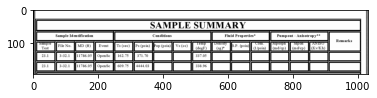

In [5]:

for fdir in img_folder.glob('*.jpg'):
    fname=getFname(str(fdir))
    print('-----------')
    print(' convert %s...' % (fname))    
    image2excel(str(fdir),str(excel_folder)+'/'+str(fname))


print('Compressing file excel_folder.zip...')
cmd='zip -r excel_folder.zip '+str(excel_folder)
p1 = subprocess.Popen(cmd,shell=True)
p1.wait()
print('download file excel_folder.zip')

In [6]:
#image2excel('C:\\Users\\User\\Downloads\\img_folder\\MicrosoftTeams-image.png','h1.xlsx')
#image2excel('C:\\Users\\User\\Downloads\\img_folder\\MicrosoftTeams-image-2.png','h2.xlsx')